In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold, cross_val_score

plt.style.use('fivethirtyeight')
display(HTML("<style>.container { width:80% !important; }</style>"))

# Read input files

In [2]:
# Decided to use both input dataset 1 and 2 to get more data to train on
#df = pd.read_parquet("../container-data/input_dataset-1.parquet")
df = pd.read_parquet("../container-data/input_dataset-2.parquet")
pred_df = pd.read_parquet("../container-data/prediction_input.parquet")

In [3]:
pred_cols = ["Bolt_"+str(x)+"_Tensile" for x in range(1,7)]+list(pred_df.columns)
pred_cols

['Bolt_1_Tensile',
 'Bolt_2_Tensile',
 'Bolt_3_Tensile',
 'Bolt_4_Tensile',
 'Bolt_5_Tensile',
 'Bolt_6_Tensile',
 'Unit_4_Power',
 'Unit_4_Reactive Power',
 'Turbine_Guide Vane Opening',
 'Turbine_Pressure Drafttube',
 'Turbine_Pressure Spiral Casing',
 'Turbine_Rotational Speed',
 'mode']

In [4]:
#df = pd.concat([df1.loc[:,pred_cols], df2.loc[:,pred_cols]], axis=0)

In [5]:
#df.to_pickle("../container-data/df.pkl")

In [6]:
#df = pd.read_pickle("../container-data/df.pkl")
df = df.loc[:,pred_cols]

In [7]:
df.columns

Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
       'Bolt_5_Tensile', 'Bolt_6_Tensile', 'Unit_4_Power',
       'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Turbine_Rotational Speed', 'mode'],
      dtype='object')

# Common preprocessing

In [8]:
# Want to extract the time of the earliest datapoint in the dataset
start_time = df.index.min()
start_time

Timestamp('1970-12-19 09:51:44')

In [9]:
df.head()

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode
timepoints,,,,,,,,,,,,,
1970-12-19 09:51:44,1598.481390,1480.989917,1684.247079,1601.359944,1635.585700,1674.848803,262.204308,2.899036,82.279976,173.955216,5310.799181,107.964278,operation
1970-12-19 09:51:45,1598.477449,1480.989528,1684.261611,1601.366508,1635.588478,1674.823883,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,operation
1970-12-19 09:51:46,1598.479316,1481.003188,1684.270504,1601.374254,1635.583464,1674.841318,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,operation
1970-12-19 09:51:47,1598.490184,1481.028827,1684.270683,1601.383179,1635.581384,1674.843245,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,operation
1970-12-19 09:51:48,1598.494073,1481.059017,1684.271062,1601.378391,1635.591746,1674.872300,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,operation


In [10]:
def common_prep(df):
    df["datetime"] = df.index.values
    df.index = np.arange(len(df))
    # We drop rows with missing. No use in trying to impute. Creates more uncertainty.
    df = df.dropna()
    return df

In [11]:
df = common_prep(df)

Want to make a holdout dataset for validation. This is held separate from crossvalidation.

The holdout-set is chosen as 20% of the data. (Not chunked in time.)

Argue that we do not get data leakage from the future, but get better validation that we are able to model dependencies across the whole dataset. 

In [12]:
def split_trn_val(df, frac=0.2):
    df = df.copy()
    val_inds = np.random.choice(df.index.values, size=int(len(df)*frac), replace=False)
    val_df = df.iloc[df.index.isin(val_inds)]
    trn_df = df.iloc[~df.index.isin(val_inds)]
    return trn_df, val_df

In [13]:
trn_df, val_df = split_trn_val(df)

In [14]:
len(trn_df), len(val_df)

(1400000, 350000)

In [15]:
val_df_dt = val_df["datetime"]

In [16]:
#trn_df.to_pickle("../container-data/trn_df.pkl")

In [17]:
#val_df.to_pickle("../container-data/val_df.pkl")

In [18]:
y_cols = ["Bolt_"+str(count)+"_Tensile" for count in range(1,7)]
y_cols

['Bolt_1_Tensile',
 'Bolt_2_Tensile',
 'Bolt_3_Tensile',
 'Bolt_4_Tensile',
 'Bolt_5_Tensile',
 'Bolt_6_Tensile']

In [19]:
def add_diff_cols(df):
    return df

In [20]:
def diff_bolt_pretension(df):
    pret = pd.read_csv("../container-data/bolt_pretension.csv", header=None)
    pret_dict = pd.Series(pret.iloc[:,1].values, index=pret.iloc[:,0]).to_dict()
    for y in y_cols:
        df[y] = df[y]-pret_dict[y.strip("_Tensile").replace("_", " ")]
    return df

def binarize_mode(df):
    df["mode"] = df["mode"].apply(lambda x: 1 if x=="start" else 0)
    return df

def categorize_mode(df):
    df["mode"] = df["mode"].apply(lambda x: "start" if x==1 else "operation")
    return df

def add_mode_switch(df):
    df["mode_switch"] = df["mode"]-(df["mode"].shift(fill_value=False))
    return df

def add_sec_since_switch(df):
    df["sec_since_switch"] = (df.groupby('mode')['datetime'].transform(lambda x: (x-x.min()).dt.seconds))
    return df

def add_days_since_start(df):
    df["days_since_start"] = (df["datetime"]-start_time).dt.days
    return df

def add_rolling_sum_speed(df, periods=[60,60*5, 60*60]):
    for period in periods:
        df["Turbine_Rotational Speed_sum"+str(period)] = df["Turbine_Rotational Speed"].rolling(period, min_periods=1).sum()
    return df

def remove_cols(df):
    remove_cols = ["datetime"]
    df = df.drop(remove_cols, axis=1)
    return df

def preprocessing(df):
    # Those that are commented out was left out as no improvement in cv score was shown
    #df = diff_bolt_pretension(df)
    df = binarize_mode(df)
    df = add_mode_switch(df)
    df = add_sec_since_switch(df)
    df = add_days_since_start(df)
    #df = add_rolling_sum_speed(df)
    df = remove_cols(df)
    df = categorize_mode(df)
    return df

def split_x_y(df):
    X = df.drop(y_cols, axis=1)
    y = df.loc[:, y_cols]
    return X, y

In [21]:
trn_df = preprocessing(trn_df)
df_X_train, df_y_train = split_x_y(trn_df)

In [22]:
val_df = preprocessing(val_df)
df_X_val, df_y_val = split_x_y(val_df)

In [23]:
x_cols = set([x for x in df_X_train.columns])-set(y_cols)
x_cols

{'Turbine_Guide Vane Opening',
 'Turbine_Pressure Drafttube',
 'Turbine_Pressure Spiral Casing',
 'Turbine_Rotational Speed',
 'Unit_4_Power',
 'Unit_4_Reactive Power',
 'days_since_start',
 'mode',
 'mode_switch',
 'sec_since_switch'}

# Make column selectors

In [24]:
X = df_X_train
y = df_y_train

In [25]:
from sklearn.compose import make_column_selector

In [26]:
df.dtypes

Bolt_1_Tensile                           float64
Bolt_2_Tensile                           float64
Bolt_3_Tensile                           float64
Bolt_4_Tensile                           float64
Bolt_5_Tensile                           float64
Bolt_6_Tensile                           float64
Unit_4_Power                             float64
Unit_4_Reactive Power                    float64
Turbine_Guide Vane Opening               float64
Turbine_Pressure Drafttube               float64
Turbine_Pressure Spiral Casing           float64
Turbine_Rotational Speed                 float64
mode                                      object
datetime                          datetime64[ns]
dtype: object

In [27]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X), num_selector(X)

(['mode', 'mode_switch'],
 ['Unit_4_Power',
  'Unit_4_Reactive Power',
  'Turbine_Guide Vane Opening',
  'Turbine_Pressure Drafttube',
  'Turbine_Pressure Spiral Casing',
  'Turbine_Rotational Speed',
  'sec_since_switch',
  'days_since_start'])

In [28]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D084DEBB80>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D084DEB9A0>)])

In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D084DEBB80>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D084DEB9A0>)])

In [40]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV(n_jobs=4, cv=3, verbose=True))
lasso_pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D084DEBB80>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D084DEB9A0>)])),
                ('lassocv', LassoCV(cv=3, n_jobs=4, verbose=True))])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(n_estimators=3, n_jobs=6, random_state=42))
rf_pipeline

In [42]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Lasso", lasso_pipeline),
    ("Random Forest", rf_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(cv=3))
stacking_regressor

StackingRegressor(estimators=[('Lasso',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline',
                                                                                 Pipeline(steps=[('standardscaler',
                                                                                                  StandardScaler()),
                                                                                                 ('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=True))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D084DEBB80>),
                                                                                ('onehotencoder',
                                             

In [ ]:
preds = {}
fitted_estimators = {}
scores = {}
for (name, est) in estimators + [("Stacking Regressor", stacking_regressor)]:
    score = cross_validate(est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=6, verbose=1, return_estimator=True)
    scores[name] = score
    print(score)
    #fitted_estimators[name] = est    
    #y_pred = cross_val_predict(est, X, y, cv=3, n_jobs=4, verbose=1)
    #preds[name] = y_pred

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


In [ ]:
scores

Random Forest
{'fit_time': array([120.70253897, 118.6899035 , 117.6768434 , 119.04456091,
        44.06354356]), 'score_time': array([0.67219067, 0.88355637, 1.2036829 , 0.78540373, 0.26384449]), 'test_r2': array([-1.16877637,  0.6962648 ,  0.79993725, -0.3798929 , -2.09036699]), 'test_neg_mean_absolute_percentage_error': array([-0.00048191, -0.0003595 , -0.00067817, -0.00066066, -0.00353979])}


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

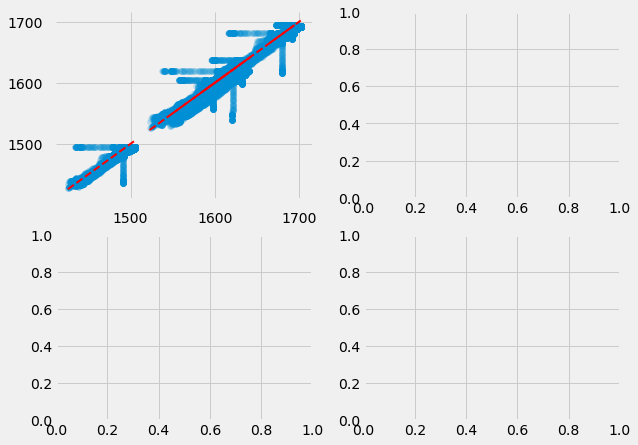

In [35]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict

def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

preds = {}
fitted_estimators = {}
scores = {}

for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
    start_time = time.time()
    print(name)
    score = cross_validate(
        est, X, y, scoring=["r2", "neg_mean_absolute_percentage_error"], n_jobs=4, verbose=0
    )
    elapsed_time = time.time() - start_time
    print(score)
    scores[name] = score
    fitted_estimators[name] = est    
    
    y_pred = cross_val_predict(est, X, y, cv=3, n_jobs=2, verbose=0)
    preds[name] = y_pred
    
    
    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_percentage_error"]),
            np.std(score["test_neg_mean_absolute_percentage_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [162]:
score

{'fit_time': array([62.23595548, 60.34824705, 64.20764685, 67.70268512, 49.05480647]),
 'score_time': array([0.40813708, 0.49805403, 0.42216635, 0.56399155, 0.31721401]),
 'test_r2': array([-2.65529353,  0.73059652,  0.79606688, -0.36640503, -1.91609672]),
 'test_neg_mean_absolute_percentage_error': array([-0.00049797, -0.00033199, -0.00067967, -0.00065913, -0.00344811])}

# Cross-validation

In [25]:
kf = KFold(n_splits=3, random_state=42, shuffle=True)
fold = 1
scores = {}
preds = {}
residuals = {}
trained_models = {}
for train_index, test_index in kf.split(df_X_train):
    scores[fold] = {}
    preds[fold] = {}
    residuals[fold] = {}
    trained_models[fold] = {}
    print(fold)
    X_train, X_test = df_X_train.iloc[train_index], df_X_train.iloc[test_index]
    for y in y_cols:
        print(y)
        scores[fold][y] = {}
        preds[fold][y] = {}
        residuals[fold][y] = {}
        trained_models[fold][y] = {}
        drop_cols = [x for x in y_cols if x!=y]
        print(drop_cols)
        y_train, y_test = df_y_train.iloc[train_index].drop(drop_cols, axis=1).values.flatten(), df_y_train.iloc[test_index].drop(drop_cols, axis=1)
        models = [RandomForestRegressor(n_estimators=5, n_jobs=4)]
        for model in models:
            model_name = str(type(model).__name__)
            print(model_name)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = mean_absolute_percentage_error(y_test, y_pred, multioutput="raw_values")
            print(score)
            scores[fold][y][model_name] = score
            preds[fold][y][model_name] = y_pred
            residuals[fold][y][model_name] = y_pred-y_test.values.flatten()
            trained_models[fold][y][model_name] = model
            break
    fold = fold+1

1
Bolt_1_Tensile
['Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor
[9.70519922e-06]
Bolt_2_Tensile
['Bolt_1_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor
[1.12374172e-05]
Bolt_3_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor
[6.50683379e-06]
Bolt_4_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor
[8.24116831e-06]
Bolt_5_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor
[9.6129345e-06]
Bolt_6_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile']
RandomForestRegressor
[1.35759922e-05]
2
Bolt_1_Tensile
['Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor

# Make predictions on validation set

In [67]:
scores = {}
preds = {}
residuals = {}
models = {}
for y in y_cols:
    print(y)
    drop_cols = [x for x in y_cols if x!=y]
    y_train = df_y_train.drop(drop_cols, axis=1).values.flatten()
    y_val = df_y_val.drop(drop_cols, axis=1).values.flatten()
    model = RandomForestRegressor(n_estimators=10, n_jobs=4)
    model.fit(df_X_train, y_train)
    y_pred = model.predict(df_X_val)
    score = mean_absolute_percentage_error(y_val, y_pred)
    print(score)
    scores[y] = score
    preds[y] = y_pred
    residuals[y] = y_pred-y_val
    models[y] = model

Bolt_1_Tensile
8.007669378342158e-06
Bolt_2_Tensile
8.72895537424203e-06
Bolt_3_Tensile
5.240965417269484e-06
Bolt_4_Tensile
6.629620618569907e-06
Bolt_5_Tensile
7.737243838789858e-06
Bolt_6_Tensile
1.0796650284518327e-05


In [68]:
len(df_y_val), len(df_y_train), len(df)

(350000, 1400000, 1750000)

# Investigate results

In [69]:
scores

{'Bolt_1_Tensile': 8.007669378342158e-06,
 'Bolt_2_Tensile': 8.72895537424203e-06,
 'Bolt_3_Tensile': 5.240965417269484e-06,
 'Bolt_4_Tensile': 6.629620618569907e-06,
 'Bolt_5_Tensile': 7.737243838789858e-06,
 'Bolt_6_Tensile': 1.0796650284518327e-05}

<AxesSubplot:>

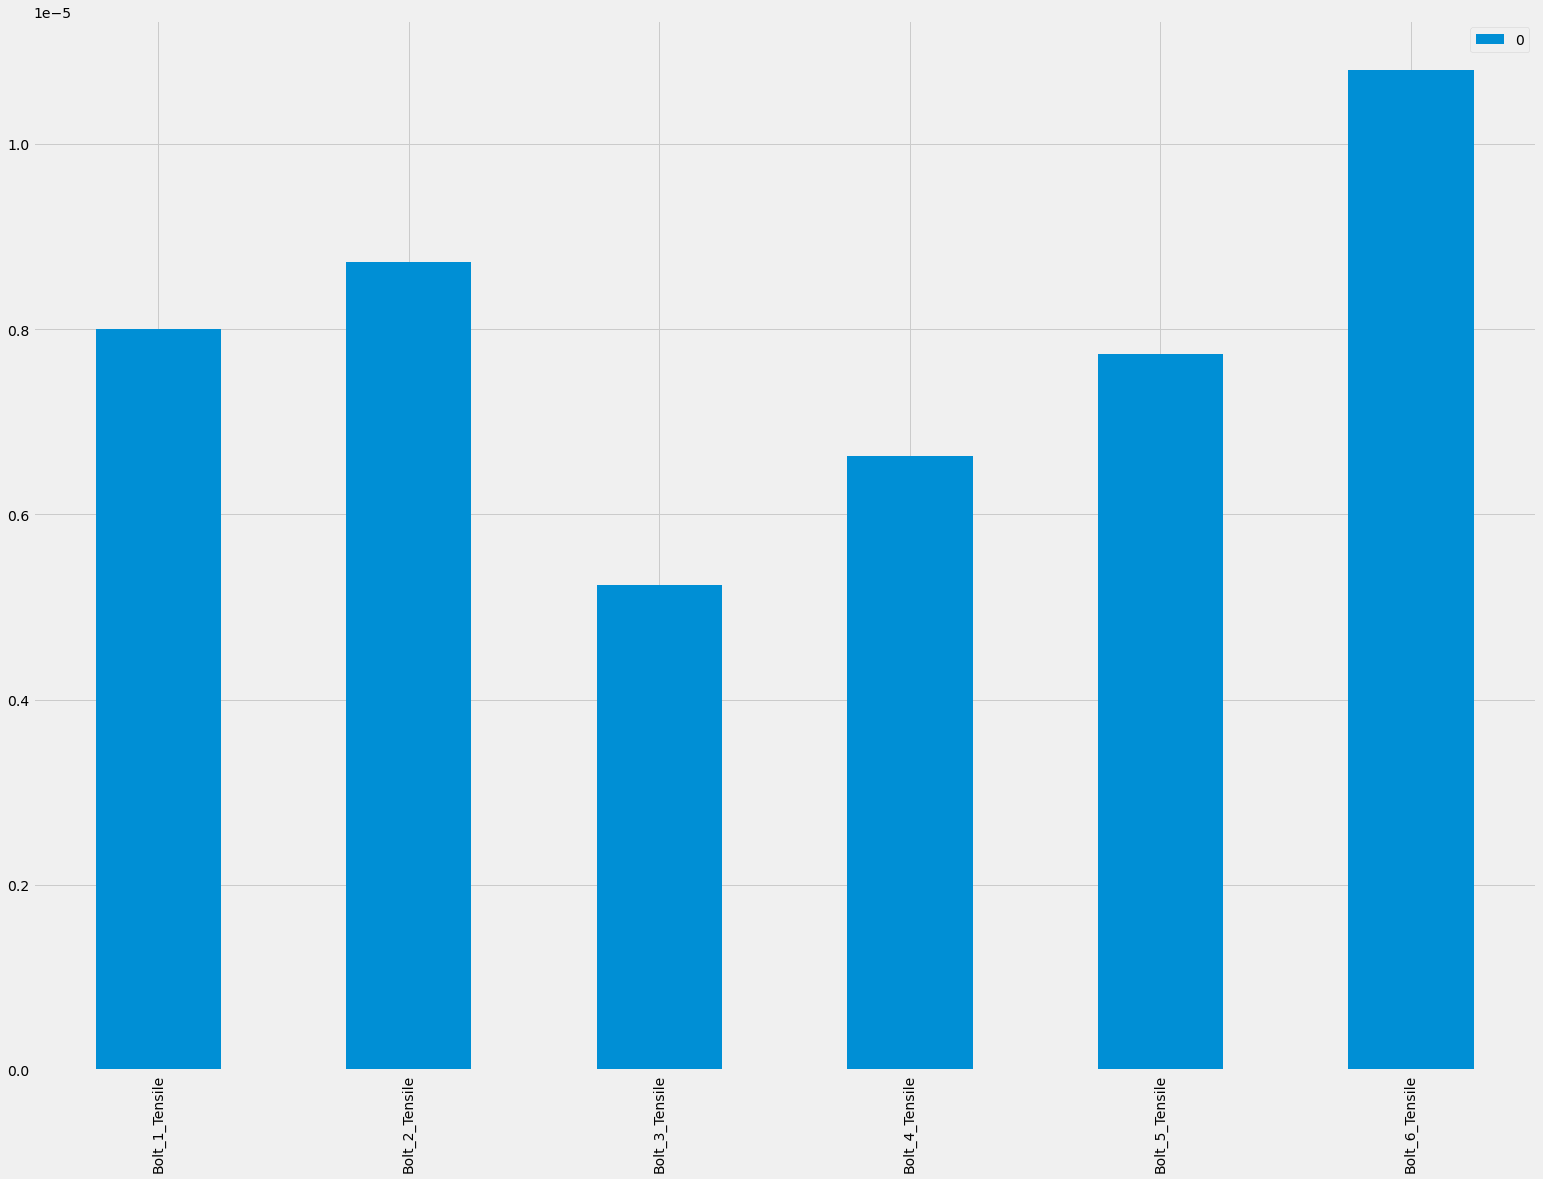

In [70]:
score_df = pd.DataFrame.from_dict(scores, orient="index")
score_df.plot(kind="bar", figsize=(24,18))

In [71]:
score_df.mean()

0    0.000008
dtype: float64

# Plot feature importances

In [72]:
models

{'Bolt_1_Tensile': RandomForestRegressor(n_estimators=10, n_jobs=4),
 'Bolt_2_Tensile': RandomForestRegressor(n_estimators=10, n_jobs=4),
 'Bolt_3_Tensile': RandomForestRegressor(n_estimators=10, n_jobs=4),
 'Bolt_4_Tensile': RandomForestRegressor(n_estimators=10, n_jobs=4),
 'Bolt_5_Tensile': RandomForestRegressor(n_estimators=10, n_jobs=4),
 'Bolt_6_Tensile': RandomForestRegressor(n_estimators=10, n_jobs=4)}

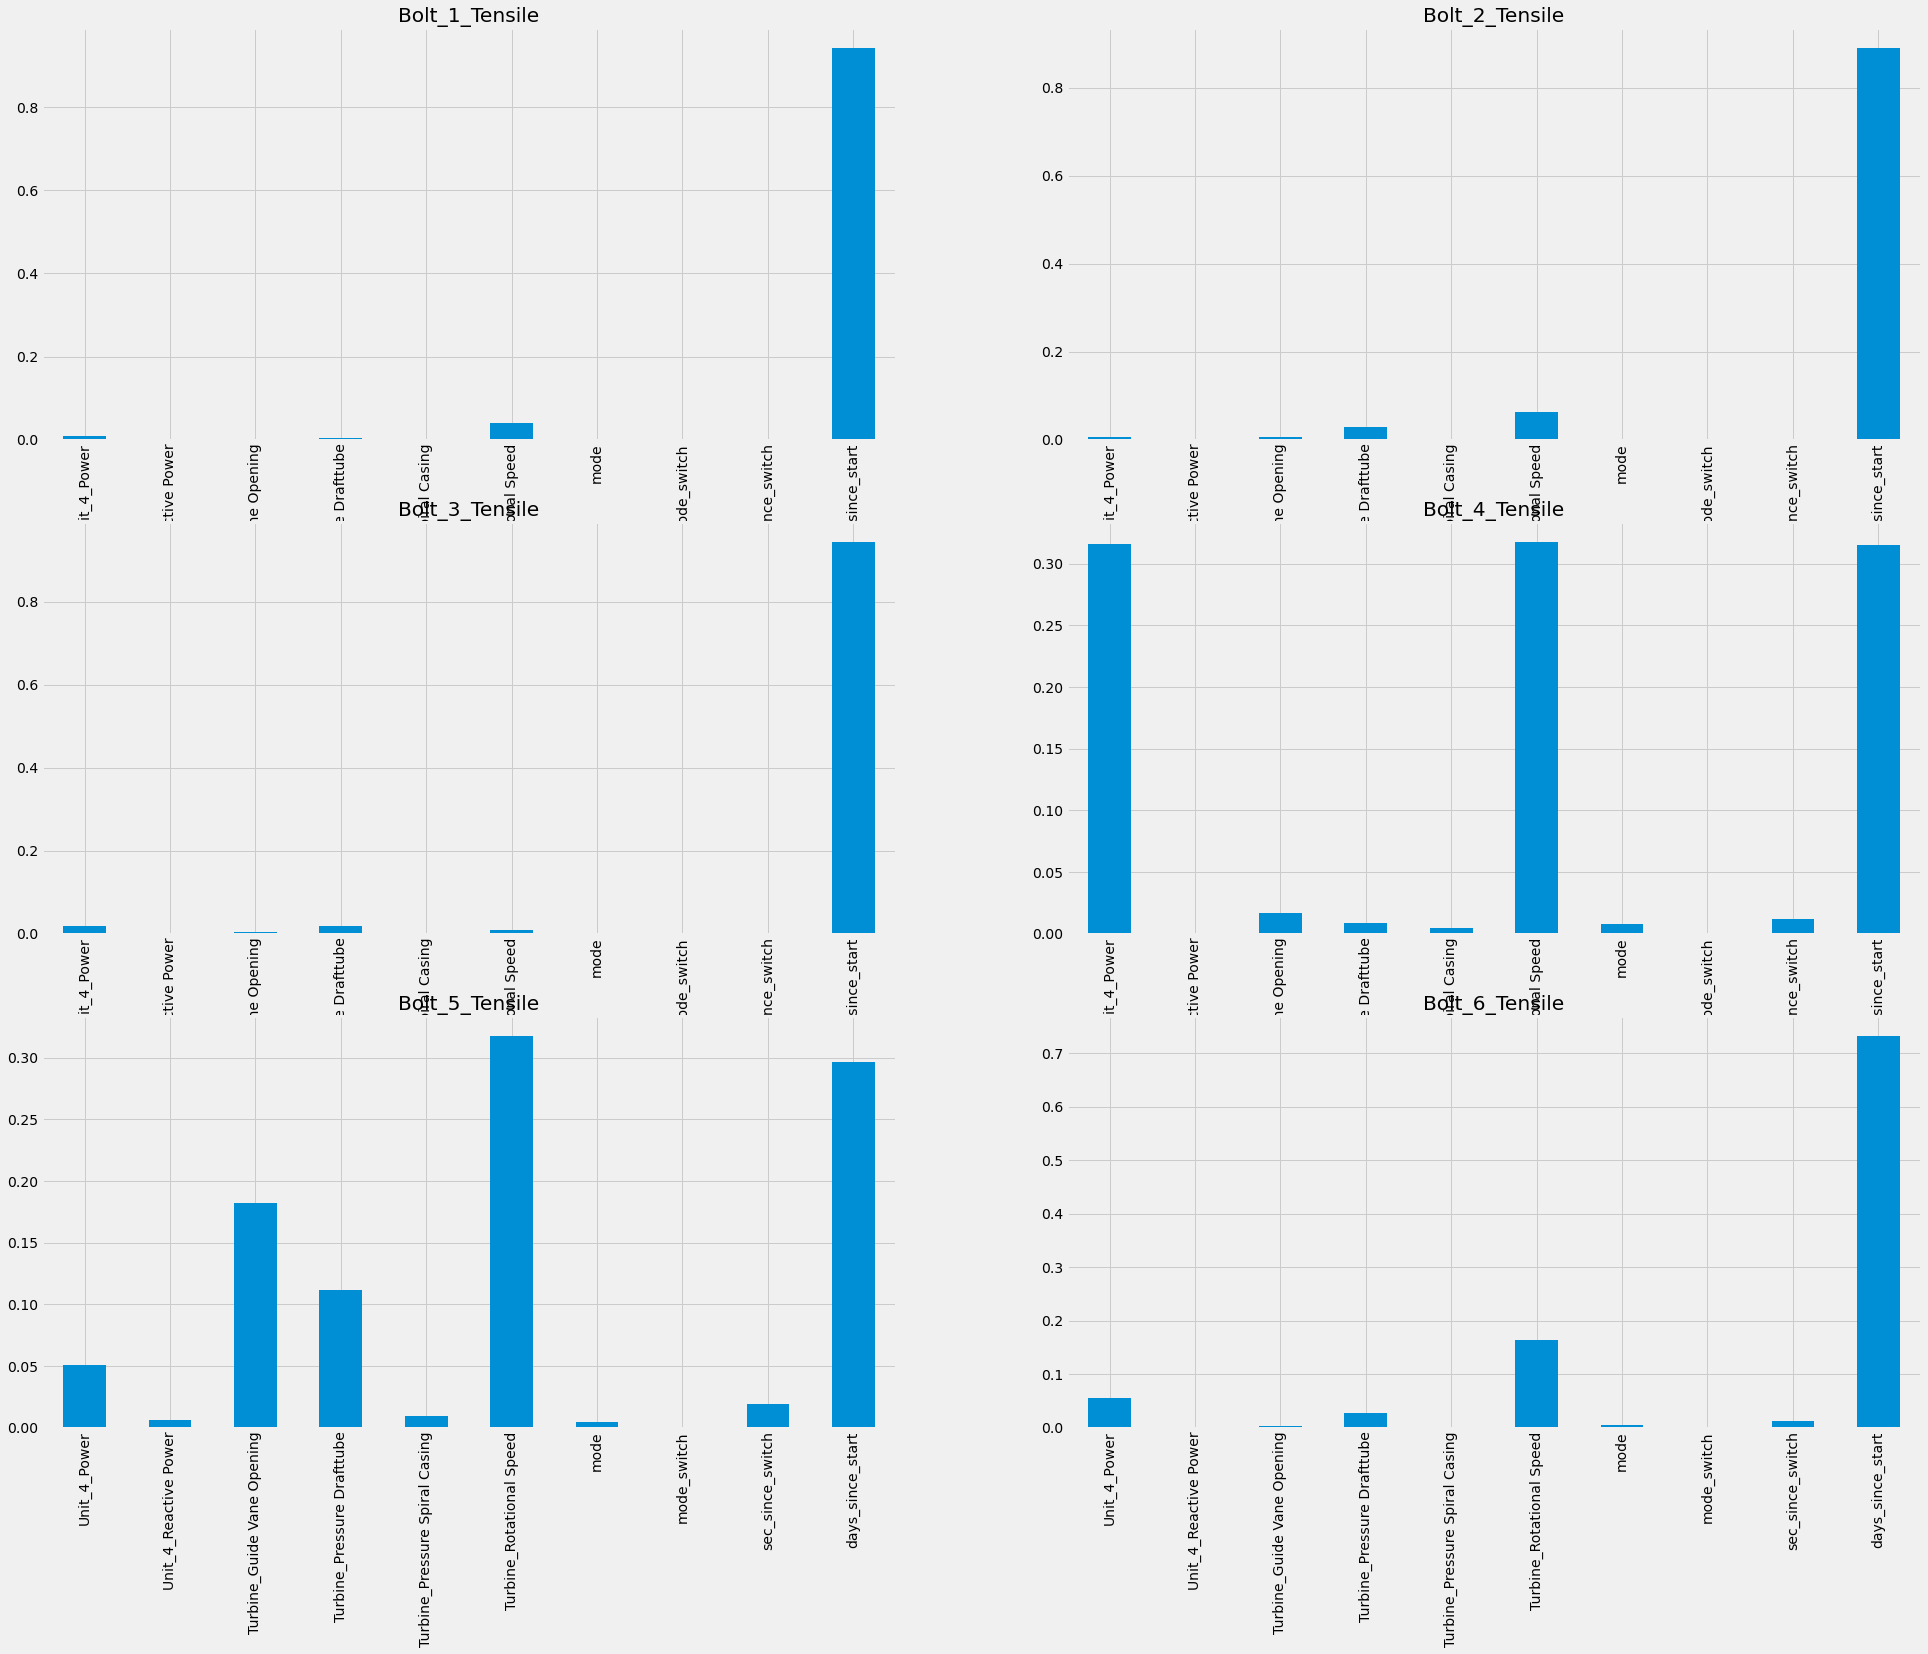

In [73]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(30,24))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        model = models[name]
        imps = pd.Series(model.feature_importances_, index=df_X_val.columns)
        imps.plot(kind="bar", ax=axes[r,c], title=name)
        count+=1

It is interesting to see that days_since_start matters more for the bolts that are more difficult to predict.

# Plot residuals

Where do we miss?

In [75]:
res_df = pd.DataFrame(data=np.transpose([residuals[y] for y in y_cols]), index=val_df_dt, columns=y_cols)

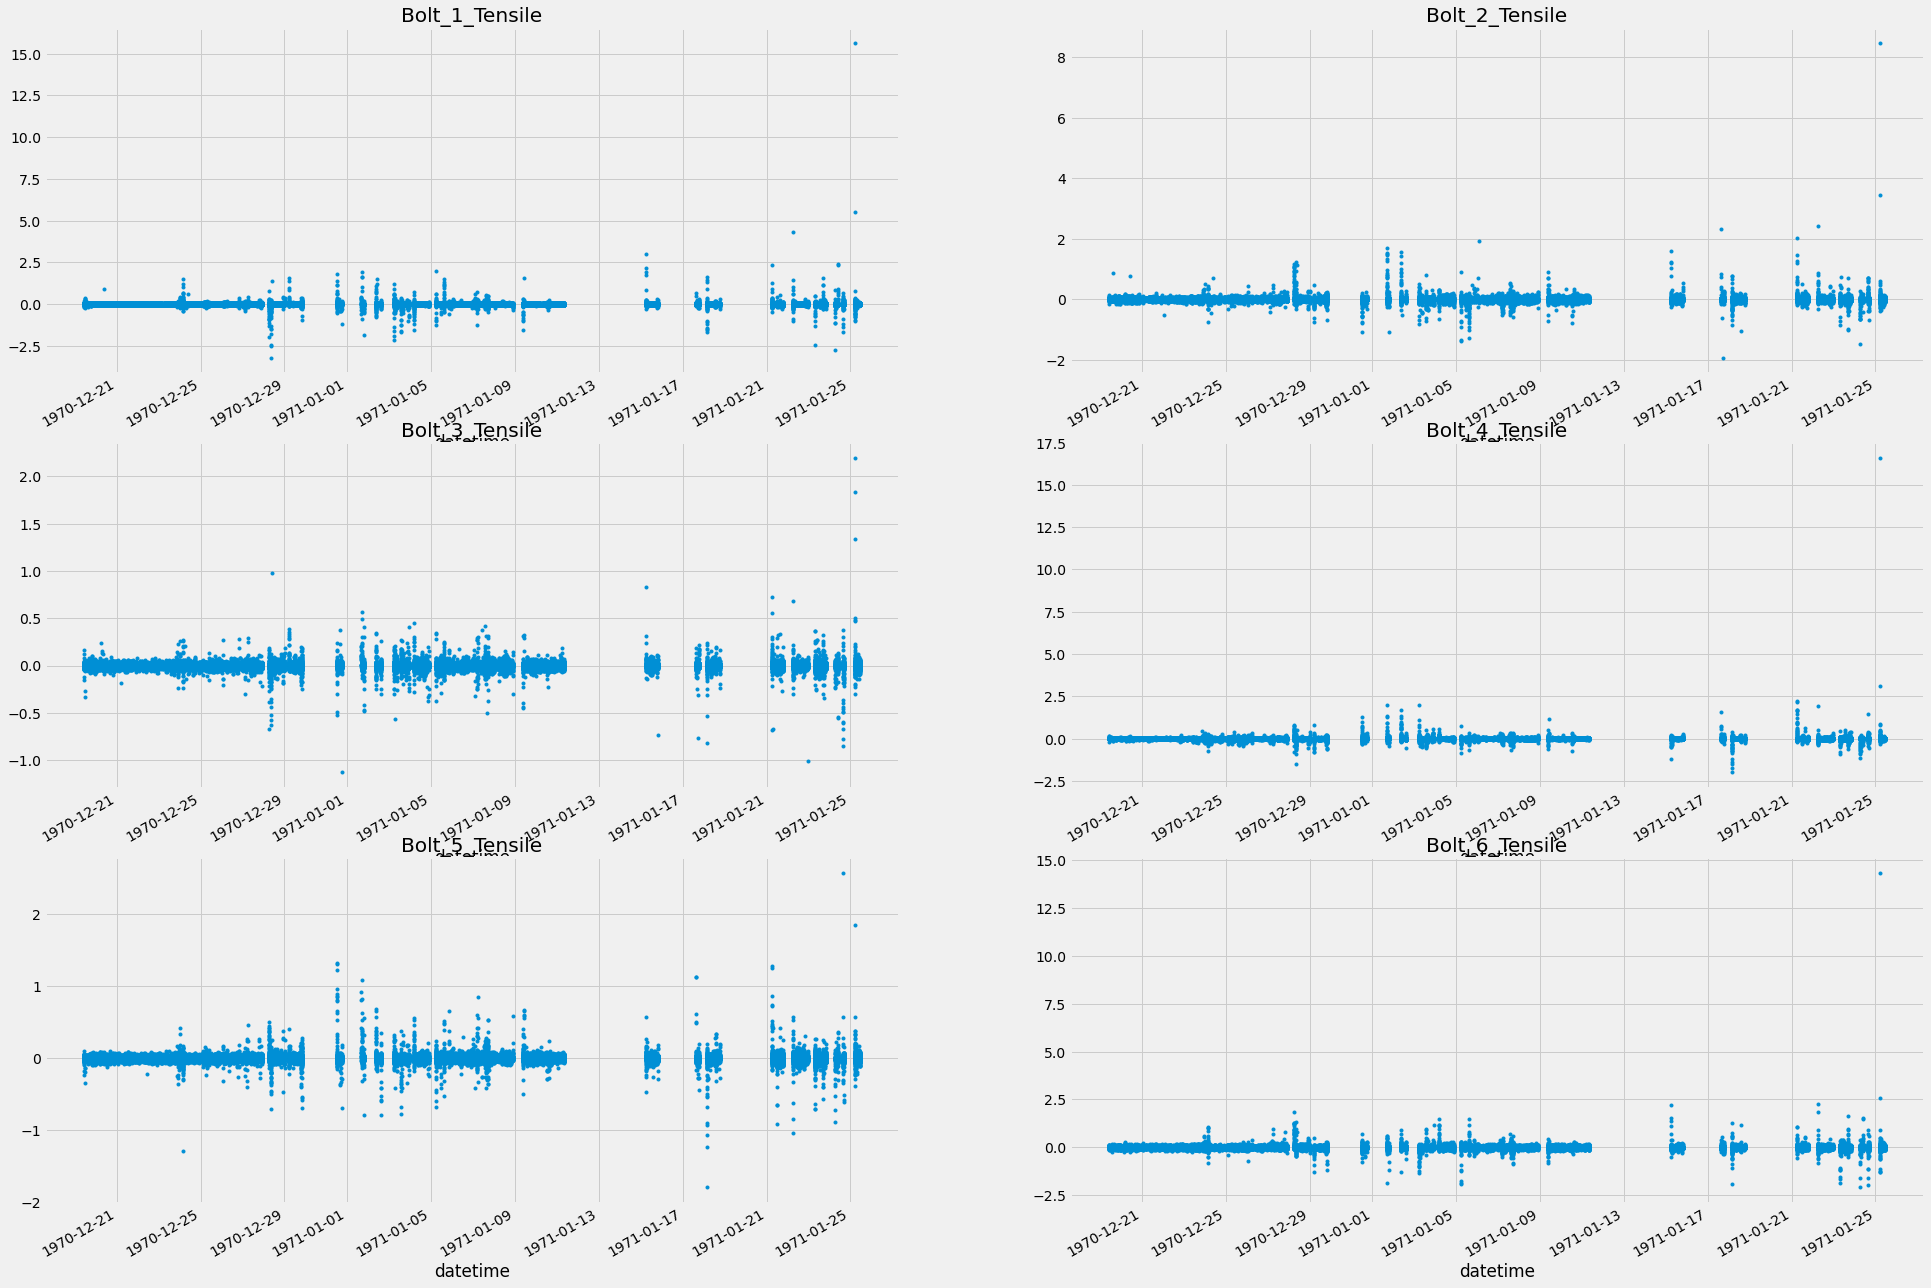

In [76]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(30,24))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        res_df[name].plot(style=".", ax=axes[r,c], title=name)
        count+=1

# Train final model with whole dataset

In [96]:
df.columns

Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
       'Bolt_5_Tensile', 'Bolt_6_Tensile', 'Unit_4_Power',
       'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Turbine_Rotational Speed', 'mode', 'datetime'],
      dtype='object')

In [99]:
final_df = preprocessing(df)

In [100]:
df_X, df_y = split_x_y(final_df) 

In [102]:
df_X.columns, df_y.columns

(Index(['Unit_4_Power', 'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
        'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
        'Turbine_Rotational Speed', 'mode', 'mode_switch', 'sec_since_switch',
        'days_since_start'],
       dtype='object'),
 Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
        'Bolt_5_Tensile', 'Bolt_6_Tensile'],
       dtype='object'))

In [103]:
model = RandomForestRegressor(n_estimators=10, n_jobs=4)
model.fit(df_X, df_y)

RandomForestRegressor(n_estimators=10, n_jobs=4)

In [104]:
pred_df = common_prep(pred_df)
pred_df_prep = preprocessing(pred_df)

## Make predictions with final model for submission

In [105]:
preds = model.predict(pred_df.loc[:,df_X.columns])

In [106]:
df_preds = pd.DataFrame(preds, columns=df_y.columns)
df_preds

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
0,1637.406924,1504.562683,1701.648466,1606.331654,1640.787830,1690.092566
1,1637.406834,1504.563439,1701.646872,1606.332248,1640.787409,1690.092243
2,1637.396661,1504.546755,1701.647424,1606.313812,1640.766319,1690.066944
3,1637.394600,1504.546721,1701.647580,1606.314901,1640.766374,1690.065423
4,1637.394600,1504.546721,1701.647580,1606.314901,1640.766374,1690.065423
...,...,...,...,...,...,...
226359,1637.484137,1502.575887,1700.004162,1605.953746,1640.354083,1691.100501
226360,1637.484137,1502.575887,1700.004162,1605.953746,1640.354083,1691.100501
226361,1637.484137,1502.575887,1700.004162,1605.953746,1640.354083,1691.100501
226362,1637.484137,1502.575887,1700.004162,1605.953746,1640.354083,1691.100501


In [107]:
out_df = pd.concat([df_preds, pred_df["datetime"]], axis=1).set_index("datetime")
out_df

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
datetime,,,,,,
1971-01-25 11:06:49,1637.406924,1504.562683,1701.648466,1606.331654,1640.787830,1690.092566
1971-01-25 11:06:50,1637.406834,1504.563439,1701.646872,1606.332248,1640.787409,1690.092243
1971-01-25 11:06:51,1637.396661,1504.546755,1701.647424,1606.313812,1640.766319,1690.066944
1971-01-25 11:06:52,1637.394600,1504.546721,1701.647580,1606.314901,1640.766374,1690.065423
1971-01-25 11:06:53,1637.394600,1504.546721,1701.647580,1606.314901,1640.766374,1690.065423
...,...,...,...,...,...,...
1971-02-03 20:16:19,1637.484137,1502.575887,1700.004162,1605.953746,1640.354083,1691.100501
1971-02-03 20:16:20,1637.484137,1502.575887,1700.004162,1605.953746,1640.354083,1691.100501
1971-02-03 20:16:21,1637.484137,1502.575887,1700.004162,1605.953746,1640.354083,1691.100501


In [108]:
orig = pd.read_parquet("../container-data/prediction_input.parquet")

In [109]:
assert (orig.index == out_df.index).all()

In [110]:
pred_df.to_csv("../container-data/prediction_output.csv")